In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Trade Data

In [44]:
df = pd.read_excel('../bbg_all.xlsx', sheet_name = 'bbg_all')
df = df.iloc[:, :20]
df = df.set_index('date')
df = df.iloc[:-1] #get rid of last X
df.index = pd.to_datetime(df.index)
df = df.sort_index(ascending=True)

days_in_month = {1:31, 2:None, 3:31, 4:30, 5:31, 6:30, 7:31, 
                 8:31, 9:30, 10:31, 11:30, 12:31}

## Assign Contracts 1

In [112]:
def assign_contracts(days_left, w_pred_off):
    return 1



trade_df = pd.DataFrame(columns = ['date', 'days_in'])
trade_df = trade_df.set_index(['date', 'days_in'])



for i in range(len(df)):
    row = df.iloc[i]
    w_pred_off = row['w/ off']
    wo_pred_off = row['w/o off']
    true_pred_off = row['true off']
    px = row['px']

    if np.isnan(w_pred_off) or \
    np.isnan(wo_pred_off) or \
    np.isnan(true_pred_off) or \
    np.isnan(px):
        continue

    date = row.name



    monthdays = days_in_month[date.month]
    if monthdays is None:
        monthdays = 28 if date.year == 2025 else 29
    days_left = monthdays - date.day
    
    num_contract = assign_contracts(days_left, w_pred_off)

    w_pred_contracts = num_contract * np.sign(w_pred_off)
    wo_pred_contracts = num_contract * np.sign(wo_pred_off)
    true_pred_contracts = num_contract * np.sign(true_pred_off)

    trade_df.loc[(date, 0), 'date'] = date
    trade_df.loc[(date, 0), 'days_left'] = days_left
    trade_df.loc[(date, 0), 'days_in'] = 0
    trade_df.loc[(date, 0), 'w_pred_contracts'] = w_pred_contracts
    trade_df.loc[(date, 0), 'wo_pred_contracts'] = wo_pred_contracts
    trade_df.loc[(date, 0), 'true_pred_contracts'] = true_pred_contracts

    ym = row['ym']
    row_ym = df[(df['ym'] == ym) & (df.index > date)]



    # i = 0, len(row_ym), +1
    for i in range(len(row_ym)):
        row_ym_loop = row_ym.iloc[i]

        w_pred_off_loop = row_ym_loop['w/ off']
        wo_pred_off_loop = row_ym_loop['w/o off']
        true_pred_off_loop = row_ym_loop['true off']
        px_loop = row_ym_loop['px']

        if np.isnan(w_pred_off_loop) or \
        np.isnan(wo_pred_off_loop) or \
        np.isnan(true_pred_off_loop) or \
        np.isnan(px_loop):
            continue


        date_loop = row_ym_loop.name
        days_left_loop = monthdays - date_loop.day
        days_in_loop = i + 1
        
        w_pred_pnl = w_pred_contracts * (px_loop - px)
        wo_pred_pnl = wo_pred_contracts * (px_loop - px)
        true_pred_pnl = true_pred_contracts * (px_loop - px)

        trade_df.loc[(date, days_in_loop), 'date'] = date_loop
        trade_df.loc[(date, days_in_loop), 'days_left'] = days_left_loop
        trade_df.loc[(date, days_in_loop), 'days_in'] = days_in_loop
        trade_df.loc[(date, days_in_loop), 'w_pred_pnl'] = w_pred_pnl
        trade_df.loc[(date, days_in_loop), 'wo_pred_pnl'] = wo_pred_pnl
        trade_df.loc[(date, days_in_loop), 'true_pred_pnl'] = true_pred_pnl


In [176]:
trade_df.to_csv('all_trades.csv')

### Trade Idea 1_1: days_in trade

In [173]:
days_in_trade_df = pd.DataFrame(columns = ['ym', 'days_in'])
days_in_trade_df = days_in_trade_df.set_index(['ym', 'days_in'])

# initialize

all_ym = ['2024-01', '2024-02', '2024-03', '2024-06', '2024-07', '2024-08',
       '2024-09', '2024-10', '2024-11', '2024-12', '2025-02']

for ym in all_ym:
    for i in range(32):
        days_in_trade_df.loc[(ym, i), 'w_pred_pnl'] = 0
        days_in_trade_df.loc[(ym, i), 'wo_pred_pnl'] = 0
        days_in_trade_df.loc[(ym, i), 'true_pred_pnl'] = 0


for date_in in trade_df.index.get_level_values(0).unique():
    rows = trade_df.loc[(slice(date_in), slice(None))]
    ym = str(date_in.date())[:7] 
    for i in range(len(rows)):
        rows_loop = rows.iloc[i]
        days_in = rows_loop.days_in
        if days_in == 0:
            continue
        days_in_trade_df.loc[(ym, days_in), 'w_pred_pnl'] += rows_loop.w_pred_pnl
        days_in_trade_df.loc[(ym, days_in), 'wo_pred_pnl'] += rows_loop.wo_pred_pnl
        days_in_trade_df.loc[(ym, days_in), 'true_pred_pnl'] += rows_loop.true_pred_pnl


In [177]:
days_in_trade_df.to_csv('days_in_trade.csv')

### Analyze

In [ ]:
df = pd.read_csv('days_in_trade.csv')
dfp = df.pivot(index='days_in', columns='ym', values=['w_pred_pnl', 'wo_pred_pnl', 'true_pred_pnl'])
dfp = dfp.swaplevel(axis=1).sort_index(axis=1)
dfp.to_csv('days_in_trade_p1.csv')

In [189]:
days_in_trade_df

w_pred_pnl  wo_pred_pnl  true_pred_pnl
ym      days_in                                        
2024-01 0               0.0          0.0            0.0
        1             117.0        113.0          179.0
        2             124.0        118.0          110.0
        3             102.0        102.0          142.0
        4             715.0        675.0          829.0
...                     ...          ...            ...
2025-02 27          -6468.0      -6468.0         9108.0
        28          -3228.0      -3228.0         7596.0
        29           -708.0       -708.0         3828.0
        30           -264.0       -264.0         1992.0
        31              0.0          0.0            0.0

[352 rows x 3 columns]

### Trade Idea 1_2: days_left trade

In [183]:
days_left_trade_df = pd.DataFrame(columns = ['ym', 'days_left'])
days_left_trade_df = days_left_trade_df.set_index(['ym', 'days_left'])

# initialize

all_ym = ['2024-01', '2024-02', '2024-03', '2024-06', '2024-07', '2024-08',
       '2024-09', '2024-10', '2024-11', '2024-12', '2025-02']

for ym in all_ym:
    for i in range(32):
        days_left_trade_df.loc[(ym, i), 'w_pred_pnl'] = 0
        days_left_trade_df.loc[(ym, i), 'wo_pred_pnl'] = 0
        days_left_trade_df.loc[(ym, i), 'true_pred_pnl'] = 0


for date_in in trade_df.index.get_level_values(0).unique():
    rows = trade_df.loc[(slice(date_in), slice(None))]
    ym = str(date_in.date())[:7] 
    for i in range(len(rows)):
        rows_loop = rows.iloc[i]
        days_in = rows_loop.days_in
        if days_in == 0:
            continue
        days_left = rows_loop.days_left
        days_left_trade_df.loc[(ym, days_left), 'w_pred_pnl'] += rows_loop.w_pred_pnl
        days_left_trade_df.loc[(ym, days_left), 'wo_pred_pnl'] += rows_loop.wo_pred_pnl
        days_left_trade_df.loc[(ym, days_left), 'true_pred_pnl'] += rows_loop.true_pred_pnl

In [181]:
days_left

np.float64(18.0)

In [185]:
trade_df

date  days_left  days_in  w_pred_contracts  \
date       days_in                                                    
2024-01-08 0       2024-01-08       23.0      0.0              -1.0   
           1       2024-01-09       22.0      1.0               NaN   
           2       2024-01-10       21.0      2.0               NaN   
           3       2024-01-11       20.0      3.0               NaN   
           4       2024-01-12       19.0      4.0               NaN   
...                       ...        ...      ...               ...   
2025-02-19 1       2025-02-20        8.0      1.0               NaN   
           2       2025-02-21        7.0      2.0               NaN   
2025-02-20 0       2025-02-20        8.0      0.0              -1.0   
           1       2025-02-21        7.0      1.0               NaN   
2025-02-21 0       2025-02-21        7.0      0.0              -1.0   

                    wo_pred_contracts  true_pred_contracts  w_pred_pnl  \
date       days_in                                                       
2024-01-08 0                     -1.0                 -1.0         NaN   
           1                      NaN                  NaN       -49.0   
           2                      NaN                  NaN       -67.0   
           3                      NaN                  NaN       -42.0   
           4                      NaN                  NaN       -20.0   
...                               ...                  ...         ...   
2025-02-19 1                      NaN                  NaN        16.0   
           2                      NaN                  NaN        21.0   
2025-02-20 0                     -1.0                 -1.0         NaN   
           1                      NaN                  NaN         5.0   
2025-02-21 0                     -1.0                 -1.0         NaN   

                    wo_pred_pnl  true_pred_pnl  
date       days_in                              
2024-01-08 0                NaN            NaN  
           1              -49.0          -49.0  
           2              -67.0          -67.0  
           3              -42.0          -42.0  
           4              -20.0          -20.0  
...                         ...            ...  
2025-02-19 1               16.0           16.0  
           2               21.0           21.0  
2025-02-20 0                NaN            NaN  
           1                5.0            5.0  
2025-02-21 0                NaN            NaN  

[1911 rows x 9 columns]

In [186]:
days_left_trade_df

w_pred_pnl  wo_pred_pnl  true_pred_pnl
ym      days_left                                        
2024-01 0             10439.0      10403.0        10813.0
        1             10331.0      10307.0        10441.0
        2             10467.0      10427.0        10929.0
        3                 0.0          0.0            0.0
        4                 0.0          0.0            0.0
...                       ...          ...            ...
2025-02 27             -528.0       -528.0         1008.0
        28               96.0         96.0          552.0
        29              300.0        300.0          276.0
        30                0.0          0.0            0.0
        31                0.0          0.0            0.0

[352 rows x 3 columns]

In [188]:
days_left_trade_df.to_csv('days_left_trade.csv')

### Analyze

In [32]:
df = pd.read_csv('days_left_trade.csv')
dfp = df.pivot(index='days_left', columns='ym', values=['w_pred_pnl', 'wo_pred_pnl', 'true_pred_pnl'])
dfp = dfp.swaplevel(axis=1).sort_index(axis=1)
dfp.to_csv('days_left_trade_p1.csv')

In [ ]:
days_left_loop = monthdays - row_ym_loop.day

In [33]:
dfp

ym              2024-01                              2024-02             \
          true_pred_pnl w_pred_pnl wo_pred_pnl true_pred_pnl w_pred_pnl   
days_left                                                                 
0               10813.0    10439.0     10403.0       37249.0    10537.0   
1               10441.0    10331.0     10307.0       36529.0    10537.0   
2               10929.0    10467.0     10427.0       37202.0    10488.0   
3                   0.0        0.0         0.0       20858.0    -3264.0   
4                   0.0        0.0         0.0           0.0        0.0   
5               10179.0    10245.0     10265.0       13680.0    13920.0   
6               10421.0    10327.0     10327.0       32378.0    11008.0   
7               10653.0    10399.0     10399.0       33753.0    10863.0   
8               10543.0    10357.0     10357.0       32250.0    11088.0   
9               10337.0    10259.0     10259.0       30474.0    11344.0   
10                  0.0        0.0         0.0           0.0        0.0   
11                  0.0        0.0         0.0           0.0        0.0   
12              10242.0    10202.0     10202.0       13880.0    13800.0   
13              10070.0    10070.0     10070.0       28702.0    11396.0   
14              10830.0    10830.0     10830.0       27062.0    12796.0   
15               7437.0     7437.0      7437.0       19592.0     8386.0   
16                  0.0        0.0         0.0        6320.0    -1482.0   
17                  0.0        0.0         0.0        4208.0    -1226.0   
18                  0.0        0.0         0.0           0.0        0.0   
19               1137.0     1137.0      1137.0        1560.0     1560.0   
20               -227.0     -227.0      -227.0        1985.0     -933.0   
21              -1427.0    -1427.0     -1427.0       -2245.0    -1315.0   
22               -833.0     -833.0      -833.0       -1075.0     -885.0   
23                  0.0        0.0         0.0        -243.0      243.0   
24                  0.0        0.0         0.0         156.0     -156.0   
25                  0.0        0.0         0.0           0.0        0.0   
26                  0.0        0.0         0.0           0.0        0.0   
27                  0.0        0.0         0.0           0.0        0.0   
28                  0.0        0.0         0.0           0.0        0.0   
29                  0.0        0.0         0.0           0.0        0.0   
30                  0.0        0.0         0.0           0.0        0.0   
31                  0.0        0.0         0.0           0.0        0.0   

ym                          2024-03                              2024-06  ...  \
          wo_pred_pnl true_pred_pnl w_pred_pnl wo_pred_pnl true_pred_pnl  ...   
days_left                                                                 ...   
0             -8443.0       40230.0    10818.0    -14274.0       40230.0  ...   
1             -8443.0       39582.0    10818.0    -14274.0       39582.0  ...   
2             -8322.0       40050.0    10782.0    -14058.0       45730.0  ...   
3            -20858.0       24606.0    -1638.0    -24606.0       30292.0  ...   
4                 0.0           0.0        0.0         0.0        5670.0  ...   
5             14000.0       15728.0    14470.0     14318.0       24545.0  ...   
6             -4298.0       37286.0    12916.0     -6700.0       46553.0  ...   
7             -5273.0       35280.0    10836.0     -9648.0       35280.0  ...   
8             -3970.0       33354.0    11070.0     -7902.0       33354.0  ...   
9             -2594.0       33870.0    13220.0     -4144.0       41393.0  ...   
10                0.0        1843.0     1671.0      2315.0        8117.0  ...   
11                0.0        2248.0     1698.0      2090.0        3294.0  ...   
12            13800.0       14340.0    14138.0     14810.0       20970.0  ...   
13            -1422.0       31040.0    13222.0     -2254.0       37671.0  ... 

In [4]:
df['dt'] = pd.to_datetime(df['dt'])

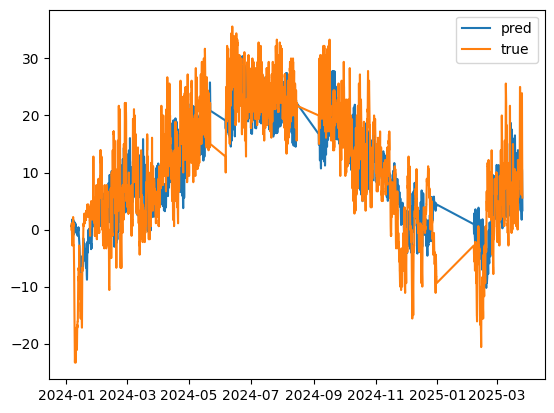

In [6]:
plt.plot(df['dt'], df['pred'], label='pred')
plt.plot(df['dt'], df['true'], label='true')
plt.legend()
plt.show();

In [ ]:
w_df_startdate24 = '2024-06-2'

,date,px
6,2025-04-11,4
7,2025-04-10,5
8,2025-04-09,5
9,2025-04-08,6
10,2025-04-07,6
...,...,...
767,2017-06-08,252
768,2017-06-07,231
769,2017-06-06,231
770,2017-06-05,184


# Weather Data

In [29]:
df = pd.read_csv('../data/datastep1.csv')

In [31]:
df['OBSERVATION_TIME_IN_UTC__STRING_AS_YYYYMMDDHHMM_'] = pd.to_datetime(df['OBSERVATION_TIME_IN_UTC__STRING_AS_YYYYMMDDHHMM_'], format = '%Y%m%d%H%M')

In [33]:
df2 = df[df['CITY_LOCATION_IDENTIFIER__UP_TO_9_ALPHANUMERIC_CHARACTERS_'] == 'KORD']

In [39]:
df2['date'] = df['OBSERVATION_TIME_IN_UTC__STRING_AS_YYYYMMDDHHMM_'].apply(lambda x: x.date())

/var/folders/4v/dp33q72x7l19qjlwm2v3_sgc0000gn/T/ipykernel_72537/2499077243.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['date'] = df['OBSERVATION_TIME_IN_UTC__STRING_AS_YYYYMMDDHHMM_'].apply(lambda x: x.date())


In [48]:
df2.groupby('date')['TEMPERATURE__FLOATING_POINT___CELSIUS_'].mean().to_csv('../kord_daily_weather.csv')

# Prediction Data